# Classification

## Getting data

In [1]:
# Import libraries

import scipy
import numpy
import sklearn
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_validate 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN

On utilise les mêmes données issues comme dans le notebook *clustering*. On les traite de même façon, on enlève les **NA** et les colonnes ayant une corrélation non-désirée. Enfin, on se retrouve avec 6 colonnes représentant  CO<sub>2 </sub> emissions, l'accès à l'éléctricité, la croissance de PIB, l'exporte, le taux de mortalité et le pourcentage de surface boisée.

In [2]:
dt = pds.read_csv('569a01d3-3538-49da-a03a-63d8d3151235_Data.txt', sep="\t") # load a pandas dataframe from csv in current directory
dt = dt[:-5]
stamps = ['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t', 'CO2 emissions (kg per 2011 PPP $ of GDP)\t', 'Access to electricity (% of population)\t', 'Electricity production from oil, gas and coal sources (% of total)\t', 'GDP per capita growth (annual %)\t', 'Industry (including construction), value added per worker (constant 2010 US$)\t', 'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', 'International tourism, receipts (% of total exports)\t', 'Exports of goods and services (% of GDP)\t', 'Imports of goods and services (% of GDP)\t', 'Urban population (% of total population)\t', 'Population, total\t', 'Death rate, crude (per 1,000 people)\t', 'Forest area (% of land area)\t']
dt.columns = stamps
dt.index = dt['Country Name\t']
dt = dt.drop(['Time\t', 'Time Code\t', 'Country Name\t', 'Country Code\t'], axis=1)
dt = dt.dropna()
dt = dt.drop(['Imports of goods and services (% of GDP)\t', 'Population, total\t', 'Urban population (% of total population)\t', 'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)\t', 'International tourism, receipts (% of total exports)\t', 'Industry (including construction), value added per worker (constant 2010 US$)\t', 'Electricity production from oil, gas and coal sources (% of total)\t'], axis=1)

dt

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),GDP per capita growth (annual %),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,,
Albania,0.184922,100.000000,1.980930,28.213001,7.219,28.191972
Algeria,0.275704,99.877052,1.699790,30.219117,4.709,0.818057
Angola,0.189387,32.000000,1.219833,44.695031,9.454,46.507420
Argentina,0.252522,100.000000,-3.578581,14.405479,7.651,10.015311
Australia,0.352370,100.000000,1.050180,21.039455,6.600,16.198664
Austria,0.155262,100.000000,-0.122369,53.386579,9.200,46.862087
Azerbaijan,0.233278,100.000000,1.522139,43.273557,5.800,13.466485
Bahrain,0.534926,100.000000,2.706112,96.050751,2.337,0.765240
Bangladesh,0.154435,62.400000,4.856108,18.989660,5.565,10.997926


## Labeling

On choisit la colonne *croissance de PIB* comme le label qu'on étudiera. On crée $n$ classes de cette colonne grâce à la discrétisation d'après les valeurs croissantes (on divise le set en $n$ morceaux de même effectif). Ensuite on procedéra en enlevant cette colonne de nos données, tout en gardant la trace de cette colonne pour pouvoir comparer les résultats. 

Pour commencer, on construira notre modèle autour du cas le plus simple, c-à-d $n=2$. Notre modèle évaluera alors si les pays possèdent un taux de croissance de PIB élevé.

In [3]:
PIB = dt['GDP per capita growth (annual %)\t']
PIB.describe()
# CO_2_sorted = CO_2.sort_values()
# CO_2_sorted.describe()

count    120.000000
mean       2.172657
std        2.421433
min       -4.731050
25%        1.025368
50%        2.167883
75%        3.563021
max        7.766030
Name: GDP per capita growth (annual %)\t, dtype: float64

In [4]:
labels = []
for i in range(120):
    if PIB[i] < 2.167883:
        labels.append(1)
    else:
        labels.append(2)
sum(labels) == 180

True

In [5]:
df = dt
df = df.drop('GDP per capita growth (annual %)\t', axis=1)
df

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,
Albania,0.184922,100.000000,28.213001,7.219,28.191972
Algeria,0.275704,99.877052,30.219117,4.709,0.818057
Angola,0.189387,32.000000,44.695031,9.454,46.507420
Argentina,0.252522,100.000000,14.405479,7.651,10.015311
Australia,0.352370,100.000000,21.039455,6.600,16.198664
Austria,0.155262,100.000000,53.386579,9.200,46.862087
Azerbaijan,0.233278,100.000000,43.273557,5.800,13.466485
Bahrain,0.534926,100.000000,96.050751,2.337,0.765240
Bangladesh,0.154435,62.400000,18.989660,5.565,10.997926


## Standardization

On remarque que nos données n'ont pas la même échelle ce qui pourrait nous poser problèmes surtout pour la méthode **K-NearestNeighbours**. Par conséquent, on va standardiser les données grâce à la z-score transformation.

In [6]:
df.describe()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.243865,87.342678,43.585065,7.878642,30.581768
std,0.133400,23.282504,29.581383,2.762408,20.179767
min,0.075353,13.500000,9.170091,2.337000,0.006462
25%,0.155270,87.990330,25.319687,5.982250,12.592530
50%,0.212866,99.988857,37.335440,7.366500,31.838990
75%,0.311126,100.000000,51.702944,9.533250,43.709366
max,0.724804,100.000000,212.607099,15.100000,73.111981


In [7]:
zscore = StandardScaler().fit(df)
dfz = pds.DataFrame(zscore.transform(df), index=df.index, columns=df.columns)
dfz.describe()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
mean,-1.517305e-16,5.958197e-16,-2.275957e-16,2.821817e-16,-6.615079e-17
std,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00
min,-1.268508e+00,-3.184893e+00,-1.168278e+00,-2.014503e+00,-1.521499e+00
25%,-6.669179e-01,2.793374e-02,-6.200509e-01,-6.893780e-01,-8.951870e-01
50%,-2.333533e-01,5.454398e-01,-2.121547e-01,-1.861742e-01,6.256233e-02
75%,5.063156e-01,5.459204e-01,2.755759e-01,6.014847e-01,6.532603e-01
max,3.620360e+00,5.459204e-01,5.737755e+00,2.625115e+00,2.116404e+00


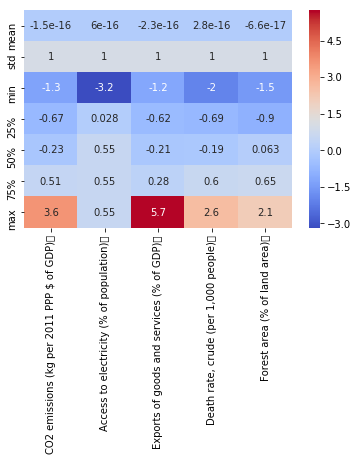

In [8]:
stats = dfz.describe()
stats = stats.drop('count',axis=0)
sns.heatmap(stats,annot=True,cmap='coolwarm')

On voit que les variables ont des moyennes quasi-nulles et l'écart-type égal à 1. 

## Models

### First *k*-nearest neighbors model

Pour déterminer la classe appartenante à chaque pays, on construit d'abord un modèle k-NN classique. Cet algorhitme assigne la classe d'un point d'après les classes de ses *k* voisins. On utilise la méthode *KNeighborsClassifier()* à partir de la bibliothèque *sklearn* par défaut.

On utilise nos données standatisées *dfz* ainsi que les données brutes et on applique la cross-validation pour déterminer la précision de notre premier modèle. On sépare les données en 5 sub-sets différents qui servent un après l'autre comme test dataset.

In [9]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

scoring = ['accuracy',
           'precision_weighted',
           'recall_weighted',
           'f1_weighted']

knn = KNeighborsClassifier()
scores = cross_validate(knn, df, labels, scoring=scoring,cv=cv, return_train_score=True)
scores = pds.DataFrame(scores).mean()

knn = KNeighborsClassifier()
scores_z = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_z = pds.DataFrame(scores_z).mean()

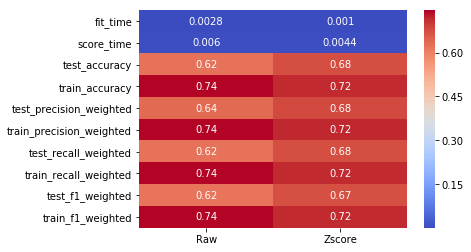

In [10]:
full_scores = pds.DataFrame({"Raw": scores, "Zscore":scores_z})
sns.heatmap(full_scores,annot=True,cmap='coolwarm')

On compare les scores du modèle avec les données brutes et ceux du modèle avec les données après z-score transformation. On regarde la ligne *test_accuracy* qui nous donne la meuilleure information sur la précision de modèle. 

Pour le modèle raw, on voit que *test_accuracy = 0.62*, cependant pour le modèle z-score *test_accuracy = 0.68*. La transformation permet de classifier mieux l'appartenance aux classes. Effectivement, certaines variables comme l'accès à l'éléctricité ou les forêts ont des valeurs proches de 100 et d'autres comme le PIB sont petites. Cette incohérence introduit plus d'erreur dans le modèle et les prédictions sont alors moins justes.

### More *k*-nearest neighbors models

On compare les différentes paramètres pour trouver quel modèle nous donne les meilleurs résultats. On garde la division en 5 sub-sets et on variera le nombre de voisins (*1, 3, 5*), le poids (*uniform, distance*) et la distance (*euclidienne, manhattan*). On créera alors 12 *k*-NN modèles pour lesquels on stockera les scores qu'on affichera après.

In [11]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

n_neighbors = [1,3,5]
weights = ["uniform", "distance"]
distances = ["euclidean","manhattan"]

scoring = ['accuracy',
           'precision_weighted',
           'recall_weighted',
           'f1_weighted']

full_scores = {}
for k in n_neighbors:
    for d in distances:
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, metric=d)
            scores = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
            scores = pds.DataFrame(scores).mean()
            full_scores[str(k)+"-"+d+"-"+w] = scores

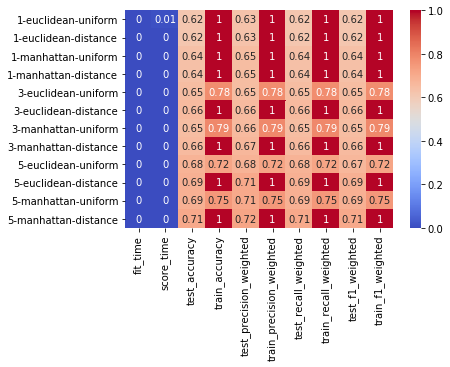

In [12]:
full_scores = pds.DataFrame(full_scores)
sns.heatmap(full_scores.T.round(2),annot=True,cmap='coolwarm')

Le meilleurs résultat on obtient avec 5-manhattan-distance modèle qui a *test_accuracy = 0.71*, il a réussi donc prédire l'appartenance de quasiment 3/4 des pays. On remarque aussi que tous les algorhitmes utilisant le poinds *distance* ont une précision absolue sur le *training* dataset.

### Decision Tree and SVM

La k-NN n'est pas la seule méthode qu'on peut utiliser pour la classification. Parmi des autres on trouve *Decision Tree* qui utilise une arborescence et *SVM (Support Vector Machine)* qui cherche une section (droite, plan) qui sépare optimalement des données en 2 groupes.

On compare la *k*-NN avec les paramètres déterminées précedemment avec un Decision Tree  et SVM par défaut. On affiche ainsi la précision des 3 méthodes. 

In [13]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='manhattan')
scores_knn = cross_validate(knn, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_knn = pds.DataFrame(scores_knn).mean()

dtc = DecisionTreeClassifier()
scores_dtc = cross_validate(dtc, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_dtc = pds.DataFrame(scores_dtc).mean()

svm = SVC(kernel='rbf')
scores_svm = cross_validate(svm, dfz, labels, scoring=scoring,cv=cv, return_train_score=True)
scores_svm = pds.DataFrame(scores_svm).mean()

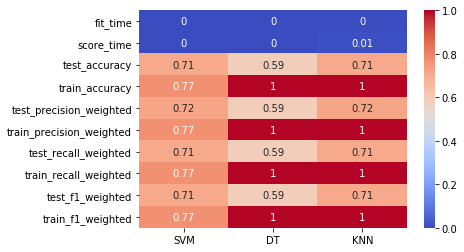

In [14]:
full_scores = pds.DataFrame({"SVM": scores_svm, "DT":scores_dtc, "KNN":scores_knn})
sns.heatmap(full_scores.T.round(2).T,annot=True,cmap='coolwarm')

Les nouvelles méthodes s'avèrent plutôt équivalentes à la k-NN. La SVM a *test_accuracy = 0.71*, égal à celle de k-NN, même si la précision de training dataset n'est pas égale à 1 comme c'est le cas pour les autres méthodes.  La Decision Tree montre *test_accuracy = 0.61*, un résultat lègerment inférieur aux autres. 

On utilise une Clustermap pour réprésenter le dataset.

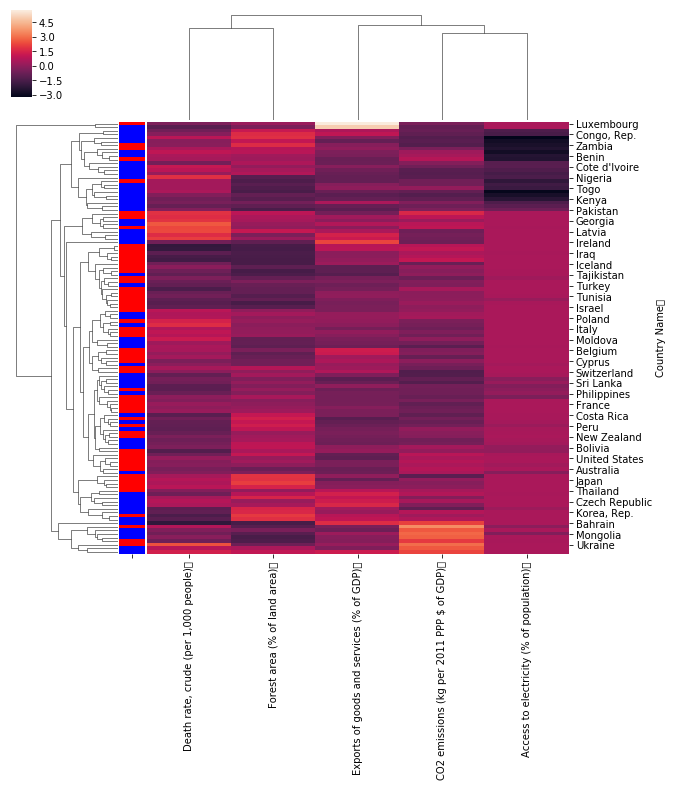

In [15]:
y = pds.Series(labels)
y.index = dfz.index
lut = dict(zip(y.unique(), "rb"))
row_colors = y.map(lut)
g = sns.clustermap(dfz, row_colors=row_colors)

Un commentaire.

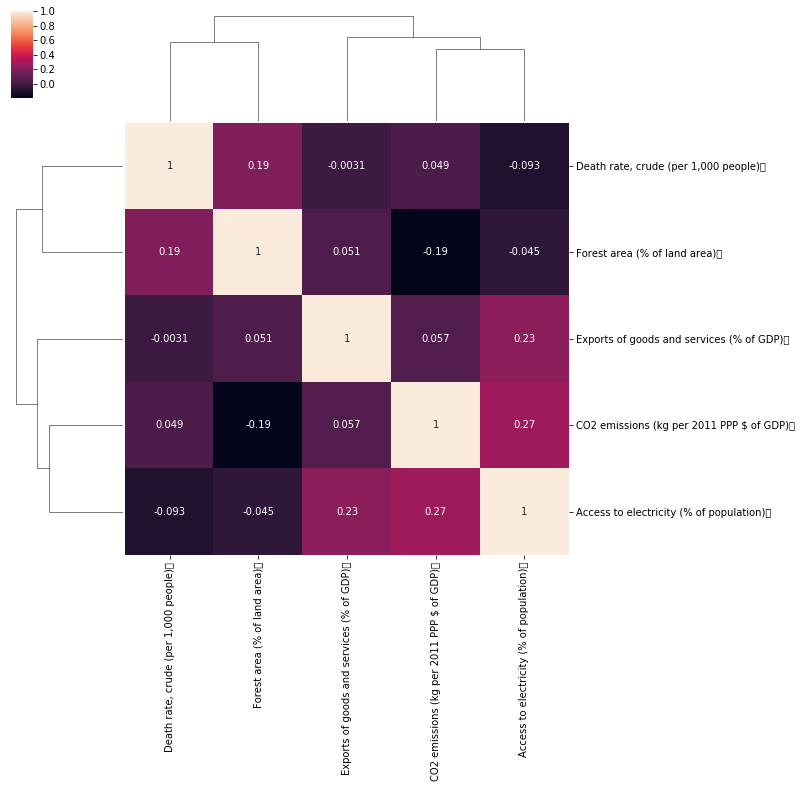

In [16]:
sns.clustermap(dfz.corr(),annot=True) # pourquoi?

### N-classes 

On utilise le clustering pour diviser le PIB en classes (mdr je sais pas trop ce que je fais)

In [17]:
sse = {}
silhouette = {}
for k in range(2,12):
    km = KMeans(k).fit(dfz)
    sse[k] = km.inertia_
    clusters = km.predict(dfz)
    silhouette[k] = metrics.silhouette_score(dfz,clusters)
sse = pds.Series(sse)
silhouette = pds.Series(silhouette)

Text(0.5,0,'k')

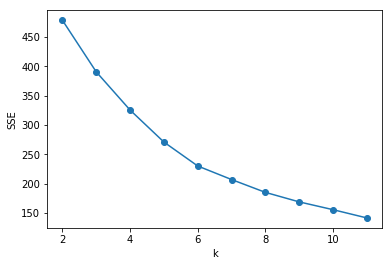

In [18]:
plt.plot(range(2,12),sse,"o-")
plt.ylabel("SSE")
plt.xlabel('k')

Text(0.5,0,'k')

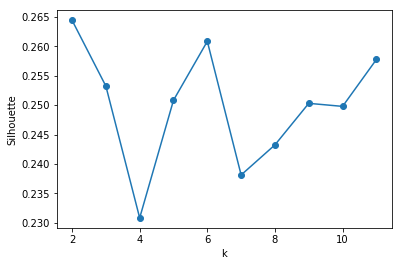

In [19]:
plt.plot(range(2,12),silhouette,"o-")
plt.ylabel("Silhouette")
plt.xlabel('k')

In [20]:
k = 6
for k in [2,3,4,5,6]:
    clusters = KMeans(k).fit_predict(dfz)
    dt = DecisionTreeClassifier().fit(dfz,clusters)
    scores_dtc = cross_validate(dt, dfz, clusters, scoring=scoring,cv=cv, return_train_score=True)
    scores_dtc = pds.DataFrame(scores_dtc).mean()
    full_scores[str(k)] = scores_dtc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramDat

In [21]:
#from sklearn.tree import plot_tree
#plot_tree(dt,filled=True, feature_names=dfz.columns)

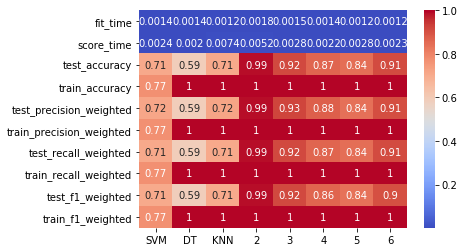

In [22]:
full_scores = pds.DataFrame(full_scores)
sns.heatmap(full_scores,annot=True,cmap='coolwarm')

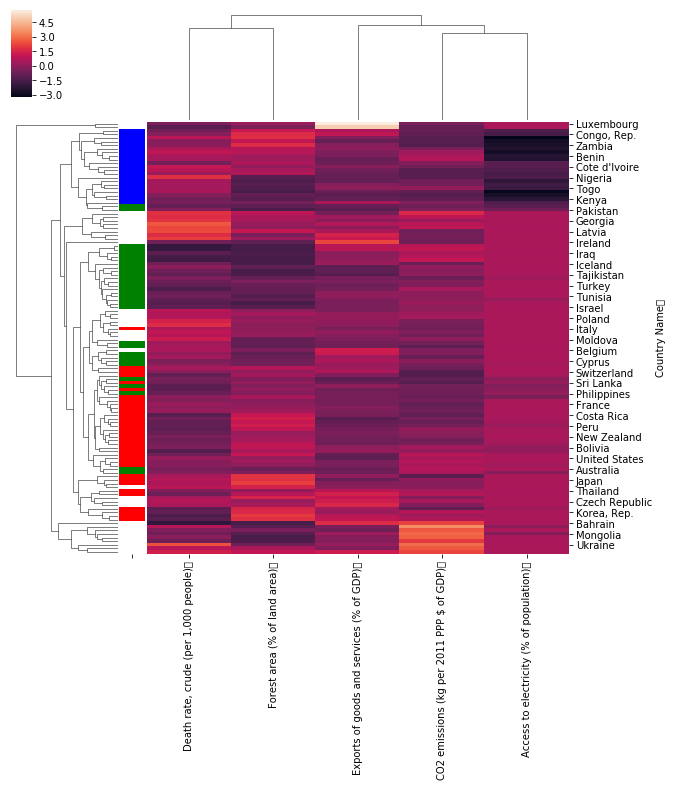

In [23]:
clusters = pds.Series(clusters)
clusters.index = dfz.index
lut = dict(zip(clusters.unique(), "rgb"))
row_colors = clusters.map(lut)
g = sns.clustermap(dfz, row_colors=row_colors)

## Outliers

On utilise une méthode non-supervisée DB-scan pour essayer de déterminer des outliers possibles que l'on pourrait enlever de notre dataset pour améliorer les modèles.

In [24]:
dbscan = DBSCAN(eps=2)
outliers = dbscan.fit_predict(dfz)
outliers = outliers == -1
df[outliers]

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
Country Name,,,,,
Luxembourg,0.188005,100.0,212.607099,6.9,35.679011
Singapore,0.125740,100.0,191.953536,4.7,23.060649
Ukraine,0.641222,100.0,48.592962,14.7,16.632775


In [25]:
dfz.describe()

,CO2 emissions (kg per 2011 PPP $ of GDP),Access to electricity (% of population),Exports of goods and services (% of GDP),"Death rate, crude (per 1,000 people)",Forest area (% of land area)
count,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
mean,-1.517305e-16,5.958197e-16,-2.275957e-16,2.821817e-16,-6.615079e-17
std,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00,1.004193e+00
min,-1.268508e+00,-3.184893e+00,-1.168278e+00,-2.014503e+00,-1.521499e+00
25%,-6.669179e-01,2.793374e-02,-6.200509e-01,-6.893780e-01,-8.951870e-01
50%,-2.333533e-01,5.454398e-01,-2.121547e-01,-1.861742e-01,6.256233e-02
75%,5.063156e-01,5.459204e-01,2.755759e-01,6.014847e-01,6.532603e-01
max,3.620360e+00,5.459204e-01,5.737755e+00,2.625115e+00,2.116404e+00


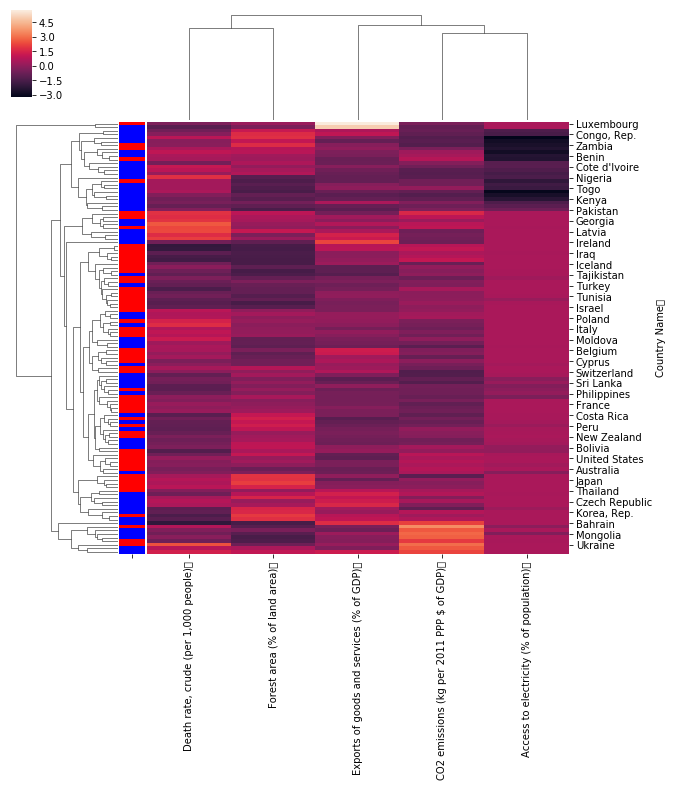

In [26]:
y.index = dfz.index
lut = dict(zip(y.unique(), "rb"))
row_colors = y.map(lut)
g = sns.clustermap(dfz, row_colors=row_colors)